<a href="https://colab.research.google.com/github/HugoShaw/WashU_projects/blob/main/RFManalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM Analysis


## type of predictive analysis
- Heuristics (rule of thumb): RFM 
- Analyst-driven model (statistical): Regression, Discrete choice model
- Data-driven model: nn, dt, recommender systems

## Facts:
- customers: demographics, behaviors
- RFM purely based on behavior
- Apply to existing customers, not to prospects
- RFM is about response rate, not profitability

## Elements of RFM:
- Recency: how long ago did customer make purchase?
- Frequency: How many purchase has the customer made in a given period?; not good compared to recency
- Monetary: How much has the customer spend in total in a given period? least predictive


## Step One:
1. pick the variable of interest (rfm)
2. sort database from the best to the worst on the variable
3. decide into how many groups to classify consumers; normally five groups (quintiles) or ten groups (deciles)
4. assign consumers to groups


## Step Two: 
1. assign every customer 3-digit code
2. take a random sample of customers 
3. approach them with an offer
4. calculate response rate per rfm cell

## Step Three: calculate break-even response rate 
* an offer is profitable if 
$$ profitabilityOfresponse × profitIfsold - costOftargeting ≥ 0 $$
* break-even response rate
$$ breakEvenResponseRate = costOftargeting ÷ profitIfsold $$

**what is the average response rate overall (population)?**
- CrossTable(data$buyer)

**Are buyers and nonbuyers having same RFM?**
- data %>% 
select(buyer, last, purch, total) %>%
group_by(buyer) %>% 
summarise(across(everything(), list(average=mean)),.groups="drop") %>% 
kable(digits=2) %>% kable_styling(position="left")

**Are R,F,M predict the same thing?**
- data %>% 
select(last, purch, total) %>%
as.matrix() %>%
rcorr()


In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
path="/content/drive/My Drive/projects/Tuango_RFM.csv"

In [26]:
import pandas as pd

data = pd.read_csv(path)
data.head()

,userid,recency,frequency,monetary,rfm1,rfm2,buyer,ordersize,platform,category,mobile_os
0,63775658,309,7,39.8,514,513,0,0,App,3,android
1,64880613,297,8,39.8,514,513,0,0,Browser,3,android
2,65051746,295,1,72.9,553,552,0,0,Browser,3,android
3,66689882,277,1,40.0,554,553,0,0,Browser,3,android
4,68839217,259,1,21.0,555,554,0,0,App,3,android


In [4]:
ct = data.groupby("buyer").agg({"buyer":"count"})
ct["percentage"] = ct["buyer"] / ct["buyer"].sum()
ct

,buyer,percentage
buyer,,
0,13507,0.969008
1,432,0.030992


In [5]:
import numpy as np
data[data.buyer==1]["ordersize"].mean()

202.3564814814815

In [27]:
quintilesTable = data[["recency","frequency","monetary"]].quantile(q=[0.2,0.4,0.6,0.8])
print(quintilesTable,type(quintilesTable))

     recency  frequency  monetary
0.2     10.0        1.0      19.6
0.4     15.0        1.0      36.0
0.6     31.0        2.0      63.6
0.8     77.0        4.0     109.0 <class 'pandas.core.frame.DataFrame'>


In [28]:
data["rec_quin"] = data["recency"].apply(
    lambda x: 1 if x<= quintilesTable["recency"][0.2] 
    else (2 if x<= quintilesTable["recency"][0.4] 
          else (3 if x <= quintilesTable["recency"][0.6] else (4 if x <= quintilesTable["recency"][0.8] else 5))))

data.head()

,userid,recency,frequency,monetary,rfm1,rfm2,buyer,ordersize,platform,category,mobile_os,rec_quin
0,63775658,309,7,39.8,514,513,0,0,App,3,android,5
1,64880613,297,8,39.8,514,513,0,0,Browser,3,android,5
2,65051746,295,1,72.9,553,552,0,0,Browser,3,android,5
3,66689882,277,1,40.0,554,553,0,0,Browser,3,android,5
4,68839217,259,1,21.0,555,554,0,0,App,3,android,5


In [29]:
avg_resp_rate_rec = data.groupby("rec_quin").agg({"buyer":"mean"}).reset_index()
avg_resp_rate_rec.rename(columns={"buyer":"avg_resp_rate"},inplace=True)
avg_resp_rate_rec.set_index("rec_quin",inplace=True, drop=True)
avg_resp_rate_rec

,avg_resp_rate
rec_quin,
1,0.060307
2,0.034165
3,0.024105
4,0.017595
5,0.008267


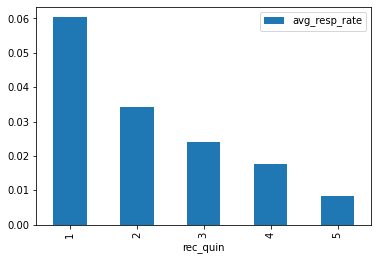

In [30]:
avg_resp_rate_rec.plot.bar()

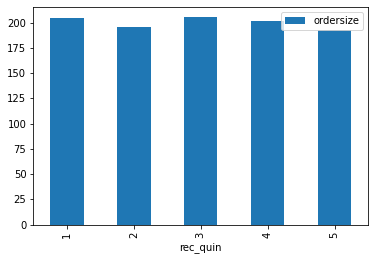

In [54]:
tuangoBuyer = data[data["buyer"]==1]
avg_order_rate_rec = tuangoBuyer.groupby("rec_quin").agg({"ordersize":"mean"})
avg_order_rate_rec.rename(columns={"buyer":"avg_spending_rate"},inplace=True)
avg_order_rate_rec = avg_order_rate_rec.reindex([1,2,3, 4,5],fill_value=0)
avg_order_rate_rec.plot.bar()

In [35]:
data["freq_quin"] = data["frequency"].apply(
    lambda x: 5 if x<=quintilesTable["frequency"][0.2] 
    else (4 if x<=quintilesTable["frequency"][0.4] 
          else (3 if x <= quintilesTable["frequency"][0.6] else (2 if x <= quintilesTable["frequency"][0.8] else 1))))

data.head()

,userid,recency,frequency,monetary,rfm1,rfm2,buyer,ordersize,platform,category,mobile_os,rec_quin,freq_quin
0,63775658,309,7,39.8,514,513,0,0,App,3,android,5,1
1,64880613,297,8,39.8,514,513,0,0,Browser,3,android,5,1
2,65051746,295,1,72.9,553,552,0,0,Browser,3,android,5,5
3,66689882,277,1,40.0,554,553,0,0,Browser,3,android,5,5
4,68839217,259,1,21.0,555,554,0,0,App,3,android,5,5


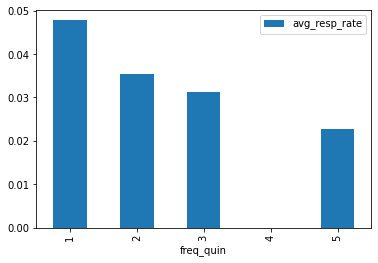

In [43]:
avg_resp_rate_freq = data.groupby("freq_quin").agg({"buyer":"mean"})
avg_resp_rate_freq.rename(columns={"buyer":"avg_resp_rate"},inplace=True)
avg_resp_rate_freq = avg_resp_rate_freq.reindex([1,2,3, 4,5],fill_value=0)
avg_resp_rate_freq.plot.bar()

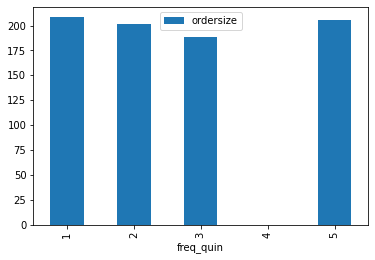

In [53]:
tuangoBuyer = data[data["buyer"]==1]
avg_order_rate_freq = tuangoBuyer.groupby("freq_quin").agg({"ordersize":"mean"})
avg_order_rate_freq.rename(columns={"buyer":"avg_spending_rate"},inplace=True)
avg_order_rate_freq = avg_order_rate_freq.reindex([1,2,3, 4,5],fill_value=0)
avg_order_rate_freq.plot.bar()

In [51]:
data["mv_quin"] = data["monetary"].apply(
    lambda x: 5 if x<= quintilesTable["monetary"][0.2] 
    else (4 if x<= quintilesTable["monetary"][0.4] 
          else (3 if x <= quintilesTable["monetary"][0.6] else (2 if x <= quintilesTable["monetary"][0.8] else 1))))

data.head()

,userid,recency,frequency,monetary,rfm1,rfm2,buyer,ordersize,platform,category,mobile_os,rec_quin,freq_quin,mv_quin
0,63775658,309,7,39.8,514,513,0,0,App,3,android,5,1,3
1,64880613,297,8,39.8,514,513,0,0,Browser,3,android,5,1,3
2,65051746,295,1,72.9,553,552,0,0,Browser,3,android,5,5,2
3,66689882,277,1,40.0,554,553,0,0,Browser,3,android,5,5,3
4,68839217,259,1,21.0,555,554,0,0,App,3,android,5,5,4


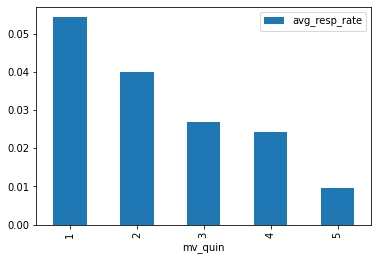

In [52]:
avg_resp_rate_mv = data.groupby("mv_quin").agg({"buyer":"mean"})
avg_resp_rate_mv.rename(columns={"buyer":"avg_resp_rate"},inplace=True)
avg_resp_rate_mv.plot.bar()

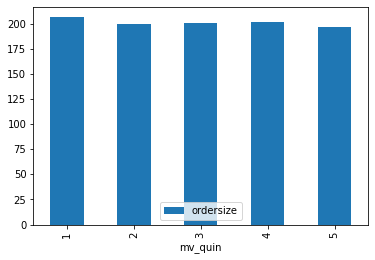

In [55]:
tuangoBuyer = data[data["buyer"]==1]
avg_order_rate_mv = tuangoBuyer.groupby("mv_quin").agg({"ordersize":"mean"})
avg_order_rate_mv.rename(columns={"buyer":"avg_spending_rate"},inplace=True)
avg_order_rate_mv = avg_order_rate_mv.reindex([1,2,3, 4,5],fill_value=0)
avg_order_rate_mv.plot.bar()

In [48]:
data.groupby("mv_quin").agg({"buyer":"mean"})

,buyer
mv_quin,
1,0.054348
2,0.040142
3,0.026937
4,0.024160
5,0.009650


**Profitability Analysis**
- Break-Even

In [56]:
unit_sales = data["ordersize"].sum() / data["buyer"].sum()
unit_profit = unit_sales * 0.5
unit_mkt_cost = 1.6
break_even = unit_mkt_cost / unit_profit
print(break_even)

0.015813676817131483


projected profit and roi

In [58]:
avg_resp_rate = sum(data["buyer"] == 1)/len(data["buyer"])
project_profit = 264841 * avg_resp_rate * unit_profit
project_profit

830471.0

In [63]:
project_ROI = project_profit / (264841 * unit_mkt_cost)
project_ROI

1.959833919219456

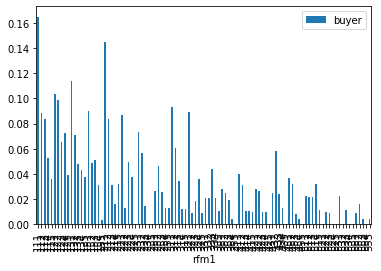

In [65]:
avg_resp_rate_rfm_sq = data.groupby("rfm1").agg({"buyer":"mean"})
avg_resp_rate_rfm_sq.plot.bar()

Auto RFM Analysis:

- Objective: construct a class to use the current dataset to automatically generate RFM analysis report
  - recency data
  - frequency data
  - monetary data
  - quantile number
  - reponse data
  - order size or other variables

- Reports should have:
  - Preliminary and Quintile Analysis
    - what percentage of customer response: average repsonse rate for buyer and non-buyer
    - what the average spending: if we have order size data, we can generate this one
    - create quantile table for recency, frequency, and monetary data
    - based on the quantile table, create bar plot for average repsonse rate for each RFM
    - if we have order size data, create bar plot for average spending rate for each RFM
  - Profitability Anlaysis
    - Break-Even point: unit sale, unit profit, unit market cost
    - ROI
    - Response rate by sequential FRM cells or by independent FRM cells


In [ ]:
class RFM(object):
  # initialize parameters
  def __init__(self):
    self.data = data
    self.xtile = 5
    pass
  
  def quantile(self):
    if self.xtile == 5:
      Q = [0.2,0.4,0.6,0.8]
      quintilesTable = self.data[["recency","frequency","monetary"]].quantile(q=Q)
    
    return quintilesTable

  def dataTable(self):
    quintilesTable = self.quantile()
    newTable = self.data.copy()
    newTable["rec_quin"] = self.data["recency"].apply(
      lambda x: 1 if x<= quintilesTable["recency"][0.2] 
      else (2 if x<= quintilesTable["recency"][0.4] 
            else (3 if x <= quintilesTable["recency"][0.6] 
                  else (4 if x <= quintilesTable["recency"][0.8] else 5))))
    
    newTable["freq_quin"] = self.data["frequency"].apply(
      lambda x: 5 if x<=quintilesTable["frequency"][0.2] 
      else (4 if x<=quintilesTable["frequency"][0.4] 
            else (3 if x <= quintilesTable["frequency"][0.6] 
                  else (2 if x <= quintilesTable["frequency"][0.8] else 1))))
    
    newTable["mv_quin"] = self.data["monetary"].apply(
      lambda x: 5 if x<= quintilesTable["monetary"][0.2] 
      else (4 if x<= quintilesTable["monetary"][0.4] 
            else (3 if x <= quintilesTable["monetary"][0.6] 
                  else (2 if x <= quintilesTable["monetary"][0.8] else 1))))
    
    return newTable

  